In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy.stats
import pdb 
import math
from PIL import Image


# 1. Seq. Bayseian learning

In [3]:
path = 'data.csv'
mat = pd.read_csv(path)
X = np.array(mat['X']).reshape(-1,)
T = np.array(mat['T']).reshape(-1,)
M = 3
beta = 1
s = 0.6

In [4]:
def sigmoid(A):
    return 1 / (1 + np.exp(-A))
    
def get_phi(X, M):
    phi = []
    for j in range(M):
        mu_j = 2 * j / M
        phi_j = sigmoid((X - mu_j) / s)
        phi.append(phi_j)  
    return np.array(phi).T
def get_gaussian(x, mean, cov):
    n = mean.shape[0]
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    N = np.sqrt((2 * np.pi)**n * cov_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', x - mean, cov_inv, x - mean)
    return np.exp(-fac / 2) / N

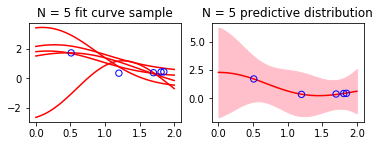

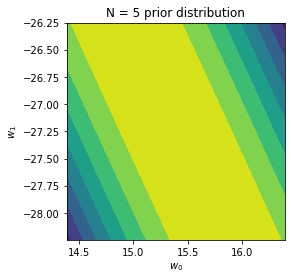

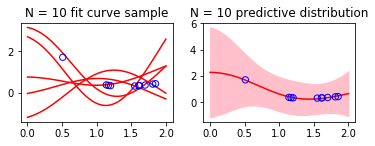

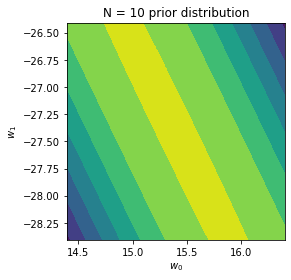

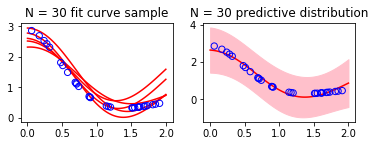

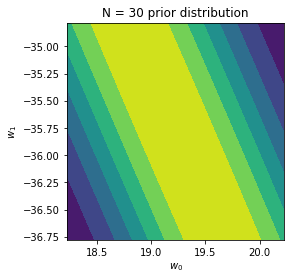

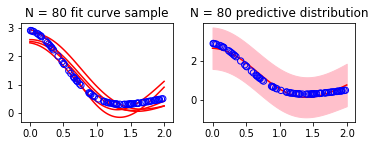

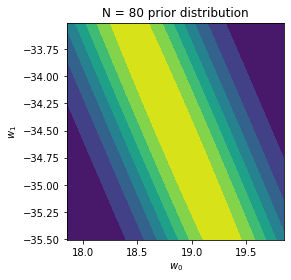

In [5]:
for n in [5, 10, 30, 80]:
    train_x = X[:n]
    train_t = T[:n]
    
    phi = get_phi(train_x, M)
    s_0_inv = 1e-6 * np.identity(M) 
    s_n_inv = s_0_inv + beta * np.dot(phi.T, phi)
    s_n = np.linalg.inv(s_n_inv) #3.50
    m_n = beta * np.dot(s_n, np.dot(phi.T, train_t)) #3.51
    
    # 1.1 Generate five curve samples from the parameter posterior distribution
    w_s = np.random.multivariate_normal(m_n, s_n, 5)
    test_x = np.linspace(0, 2, 100)
    test_phi = get_phi(test_x, M)
    
    #pdb.set_trace()
    plt.subplot(221)
    for w_s_i in w_s:
        test_y = np.dot(test_phi, w_s_i)
        plt.plot(test_x, test_y, 'r', zorder = 0)
    plt.scatter(X[:n], T[:n], facecolor = "none", edgecolor = "b", s = 40, zorder = 1)
    plt.title('N = ' +str(n) + ' fit curve sample')
    #plt.show()
    
    # 1.2 Plot the predictive distribution
    m_x = np.dot(test_phi, m_n) # mean curve
    v_x = np.diag(1 + np.dot(np.dot(test_phi, s_n), test_phi.T))
    
    plt.subplot(222)
    plt.fill_between(test_x, m_x - v_x, m_x + v_x, color = 'pink', zorder = 0)
    plt.plot(test_x, m_x, 'r', zorder = 1)
    plt.scatter(X[:n], T[:n], facecolor = "none", edgecolor = "b", s = 40, zorder = 2)
    plt.title('N = ' + str(n) + ' predictive distribution')
    plt.show()
    
    # 1.3 Select two weights {w0, w1} and plot the prior distributions
    mean = m_n[:2]
    cov = s_n[:2, :2]
    w0, w1 = np.meshgrid(
        np.linspace(mean[0] - 1, mean[0] + 1, 100),
        np.linspace(mean[1] - 1, mean[1] + 1, 100))
    w = np.array([w0, w1]).transpose(1, 2, 0)
    
    # plt.subplot()
    #plt.figure(figsize=(20,20), )
    plt.contourf(w0, w1, get_gaussian(w, mean, cov))
    plt.gca().set_aspect('equal')
    # pdb.set_trace()
    #plt.xticks(range(math.floor(np.min(w0)), math.ceil(np.max(w0))))
    #plt.yticks(range(math.floor(np.min(w1)), math.ceil(np.max(w1))))
    
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")
    plt.title('N = ' + str(n)+ ' prior distribution')
    plt.show()

# 2 logistic regression

In [5]:
import os
data_path = 'Fashion_MNIST/Fashion_MNIST'

data = []
for subject in os.listdir(data_path):
    images = []
    for file in os.listdir(f'{data_path}/{subject}'):
        im = Image.open(f'{data_path}/{subject}/{file}')
        images.append(np.array(im))
    data.append(images)

# hyperparameters
N = 5 # 5 class
Batch_size = 40 # batch size
class_num = 64 # each class 64 sample

In [6]:
# Nornamlize
data = np.array(data).astype(float) / 255

# Random sample
train_data = []
test_data = []

for i in range(data.shape[0]):
    idx = np.arange(class_num)
    np.random.shuffle(idx)
    # pdb.set_trace()
    train_data.append(data[i][idx[8:]])
    test_data.append(data[i][idx[:8]])

# preprocess train:test = 56:8
train_data = np.array(train_data) #(5,8,28,28)
test_data = np.array(test_data) #(5,56,28,28)

train_x = train_data.reshape((N*(class_num-8),-1)) # (280, 784)
test_x = test_data.reshape((N*(8),-1)) # (40, 784)

a = np.arange(N)
train_y = a.repeat(class_num-8) 
train_y = np.eye(N)[train_y] # (320, 5)
test_y = a.repeat(8) 
test_y = np.eye(N)[test_y] # (320, 5)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(280, 784)
(40, 784)
(280, 5)
(40, 5)


In [7]:
#%%
def Hessian(x, y):
    # PHI^T R PHI
    R = np.trace(np.dot(y, (1 - y).T))
    return np.dot(np.dot(x.T, R), x)
def softmax(a):
    return np.exp(a) / np.sum(np.exp(a), axis = 1, keepdims = True)

def cross_entropy(y, t):
    return -np.sum(t * np.log(y + 1e-7))

def accuracy(y, t):
    return np.sum(np.argmax(y, axis = 1) == np.argmax(t, axis = 1)) / y.shape[0]

[Epoch 1] err: 0.8684964630558367, acc: 0.7714285714285715
[Epoch 2] err: 0.6829520571912501, acc: 0.8285714285714286
[Epoch 3] err: 0.5519004066340542, acc: 0.8642857142857143
[Epoch 4] err: 0.47560343802102706, acc: 0.8928571428571429
[Epoch 5] err: 0.42693790684223154, acc: 0.9142857142857143
[Epoch 6] err: 0.392890132425208, acc: 0.9285714285714286
[Epoch 7] err: 0.3673341915122285, acc: 0.9321428571428572
[Epoch 8] err: 0.3471121082458654, acc: 0.9321428571428572
[Epoch 9] err: 0.3304638286689611, acc: 0.9321428571428572
[Epoch 10] err: 0.3163420115587779, acc: 0.9357142857142857
[Epoch 11] err: 0.3040879476660353, acc: 0.9392857142857143
[Epoch 12] err: 0.2932672870218324, acc: 0.9464285714285714
[Epoch 13] err: 0.28358164479311226, acc: 0.9464285714285714
[Epoch 14] err: 0.2748185317711495, acc: 0.9464285714285714
[Epoch 15] err: 0.26682171689580436, acc: 0.9464285714285714
[Epoch 16] err: 0.2594730076435806, acc: 0.9535714285714286
[Epoch 17] err: 0.252680677267637, acc: 0.9535

[Epoch 140] err: 0.07074265969481719, acc: 0.9892857142857143
[Epoch 141] err: 0.07032583439126816, acc: 0.9892857142857143
[Epoch 142] err: 0.06991374582165508, acc: 0.9892857142857143
[Epoch 143] err: 0.06950631322965725, acc: 0.9892857142857143
[Epoch 144] err: 0.06910345766859394, acc: 0.9892857142857143
[Epoch 145] err: 0.06870510195365823, acc: 0.9892857142857143
[Epoch 146] err: 0.0683111706154695, acc: 0.9892857142857143
[Epoch 147] err: 0.06792158985491688, acc: 0.9892857142857143
[Epoch 148] err: 0.06753628749926407, acc: 0.9892857142857143
[Epoch 149] err: 0.06715519295948537, acc: 0.9892857142857143
[Epoch 150] err: 0.06677823718880285, acc: 0.9892857142857143
[Epoch 151] err: 0.06640535264239518, acc: 0.9892857142857143
[Epoch 152] err: 0.06603647323824803, acc: 0.9892857142857143
[Epoch 153] err: 0.06567153431911664, acc: 0.9892857142857143
[Epoch 154] err: 0.06531047261557006, acc: 0.9892857142857143
[Epoch 155] err: 0.0649532262100898, acc: 0.9892857142857143
[Epoch 156

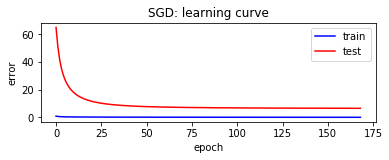

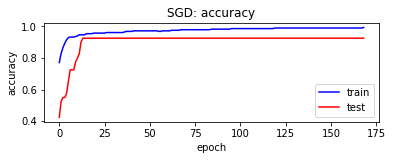

[Epoch 1] err: 76.93855504579471, acc: 0.4178571428571428
[Epoch 2] err: 68.96442397239504, acc: 0.44642857142857145
[Epoch 3] err: 50.02791196163731, acc: 0.5535714285714286
[Epoch 4] err: 36.18988183463815, acc: 0.7000000000000001
[Epoch 5] err: 28.510911874623265, acc: 0.7928571428571428
[Epoch 6] err: 24.220725384615687, acc: 0.8392857142857142
[Epoch 7] err: 21.57113366338236, acc: 0.8607142857142857
[Epoch 8] err: 19.749585359128314, acc: 0.8821428571428571
[Epoch 9] err: 18.370483980468652, acc: 0.8964285714285715
[Epoch 10] err: 17.262794365634182, acc: 0.9000000000000001
[Epoch 11] err: 16.33958626789675, acc: 0.9071428571428573
[Epoch 12] err: 15.550344596813508, acc: 0.9142857142857144
[Epoch 13] err: 14.862950888668209, acc: 0.9142857142857144
[Epoch 14] err: 14.25565257784364, acc: 0.9142857142857144
[Epoch 15] err: 13.713004886691921, acc: 0.9142857142857144
[Epoch 16] err: 13.223629770013092, acc: 0.9142857142857144
[Epoch 17] err: 12.778893258587377, acc: 0.914285714285

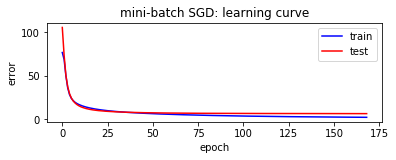

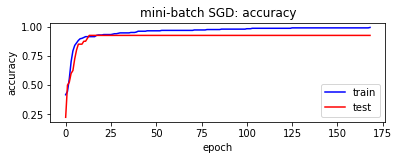

[Epoch 1] err: 450.64247548158306, acc: 0.2
[Epoch 2] err: 235.3525058448758, acc: 0.7178571428571429
[Epoch 3] err: 303.4276254258402, acc: 0.41785714285714287
[Epoch 4] err: 696.0876108442318, acc: 0.5035714285714286
[Epoch 5] err: 144.69081958309079, acc: 0.8285714285714286
[Epoch 6] err: 277.3464743978228, acc: 0.7607142857142857
[Epoch 7] err: 413.86002568266406, acc: 0.5857142857142857
[Epoch 8] err: 709.1403843722541, acc: 0.75
[Epoch 9] err: 276.40805432621045, acc: 0.6
[Epoch 10] err: 473.850118124152, acc: 0.5785714285714286
[Epoch 11] err: 206.7475314470436, acc: 0.7
[Epoch 12] err: 318.45843015108176, acc: 0.7
[Epoch 13] err: 355.0818358544026, acc: 0.7607142857142857
[Epoch 14] err: 276.93349705440755, acc: 0.7714285714285715
[Epoch 15] err: 292.5629862297863, acc: 0.7642857142857142
[Epoch 16] err: 192.09656280599754, acc: 0.8142857142857143
[Epoch 17] err: 195.15833196142424, acc: 0.8142857142857143
[Epoch 18] err: 159.3935893636779, acc: 0.8607142857142858
[Epoch 19] er

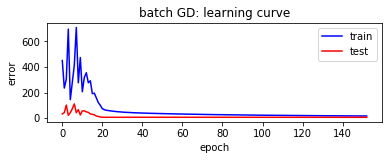

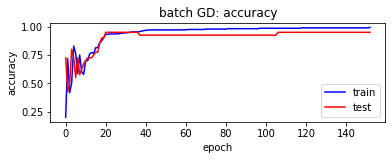

here I come
[Epoch 1] err: 450.64247548158306, acc: 0.2
here I come
[Epoch 2] err: 449.6429228076661, acc: 1.0
[result] train err: 449.6429228076661, train acc: 1.0, test err: 64.13401828318676, test acc: 0.9


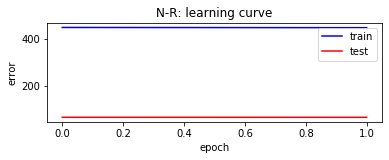

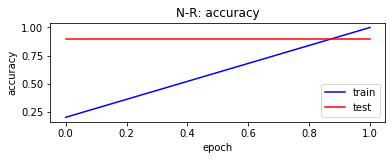

In [8]:
# Training
batch = [1, Batch_size, (N*56), (N*56)]
batch_name = ['SGD', 'mini-batch SGD', 'batch GD', 'N-R']
lr = 1e-3

for idx in range(4):
    b = batch[idx]
    error_history = []
    acc_history = []
    test_error_history = []
    test_acc_history = []
    
    epoch = 0
    w = np.zeros((N, 28*28))
    
    while True: # each epoch
        epoch += 1
        batch_err_history =[]
        batch_acc_history = []
        for i in range(int(N*56/b)): # each batch
            batch_x = train_x[i*b:(i+1)*b]
            batch_y = train_y[i*b:(i+1)*b]
            y = softmax(np.dot(batch_x, w.T))

            error = cross_entropy(y, batch_y)
            batch_err_history.append(error)

            acc = accuracy(y, batch_y)
            batch_acc_history.append(acc)
            
            # update w:            
            # N-R method
            if (batch_name[idx]=='N-R'):
                print('here I come')
                H = Hessian(batch_x, y)
                H_inv = np.linalg.pinv(H)

                update = np.dot(np.dot((y - batch_y).T, batch_x), H_inv)
                w = w - update
            else:
                w = w - lr * np.dot((y - batch_y).T, batch_x)
            
        error = sum(batch_err_history)/len(batch_err_history)
        acc = sum(batch_acc_history)/len(batch_acc_history)
        

        error_history.append(error)
        acc_history.append(acc)
        
        # Prediction
        pred_y = softmax(np.dot(test_x, w.T))
        pred_y_class = np.argmax(pred_y, axis = 1) + 1
        pred_acc = accuracy(pred_y, test_y)
        pred_err = cross_entropy(pred_y,test_y)

        test_acc_history.append(pred_acc)
        test_error_history.append(pred_err)

        print(f'[Epoch {epoch}] err: {error}, acc: {acc}')

        if (1-acc) < 0.01 or epoch==2000:
            print(f'[result] train err: {error}, train acc: {acc}, test err: {pred_err}, test acc: {pred_acc}')
            break
    plt.subplot(211)
    plt.title(batch_name[idx] + ': learning curve')
    plt.plot(range(epoch), error_history, 'b', label='train')
    plt.plot(range(epoch), test_error_history, 'r', label='test')
    plt.xlabel('epoch')
    plt.ylabel('error')
    plt.legend(loc='best')
    plt.show()
    
    
    plt.subplot(212)
    plt.title(batch_name[idx] + ': accuracy')
    plt.plot(range(epoch), acc_history, 'b', label='train')
    plt.plot(range(epoch), test_acc_history, 'r', label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

    #%%


# 2.2-2.3 PCA

In [9]:
# Find the covariance matrix: p570
mean = np.sum(train_x, axis = 0) / train_x.shape[0] #(784,)
B = train_x - np.tile(mean, (280,1))
cov = np.dot(B.T, B) / 280
print(cov.shape)

(784, 784)


(784, 784)


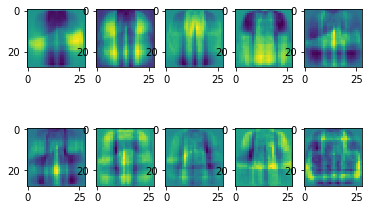

In [10]:
# Find the eigenvalues and eigenvectors of the covariance matrix
D, V = np.linalg.eigh(cov)

# Sort the columns of the eigenvector V in order of decreasing eigenvalue
idx = np.argsort(D)[::-1]
D2 = D[idx]
V2 = V[:,idx]
print(V2.shape) #(784, 784) = (feature, importance)

# Print top five eigenvectors
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(V2[:,i].T.reshape(28, 28))
plt.show()

[result] train err: 1.3648558168846634, train acc: 0.37857142857142856, test err: 54.79615170967975, test acc: 0.35
[result] train err: 49.61476575661627, train acc: 0.5035714285714287, test err: 50.02199971968578, test acc: 0.425
[result] train err: 324.75211302493244, train acc: 0.5642857142857143, test err: 46.95362906133332, test acc: 0.475


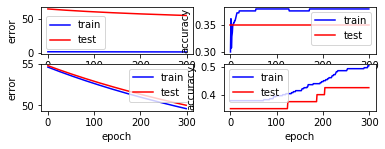

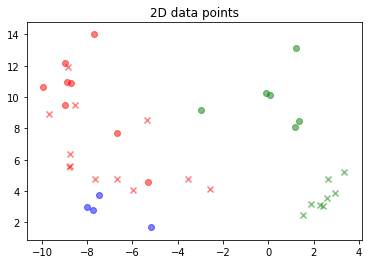

[result] train err: 309.6912513185886, train acc: 0.5714285714285714, test err: 44.924028253021845, test acc: 0.525


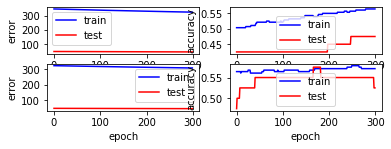

[result] train err: 1.2909646463625752, train acc: 0.8357142857142857, test err: 51.79075580473838, test acc: 0.825
[result] train err: 43.919454440279914, train acc: 0.8785714285714287, test err: 44.108455349220975, test acc: 0.875
[result] train err: 270.64392487975294, train acc: 0.8857142857142857, test err: 38.820774219988195, test acc: 0.875
[result] train err: 211.69846860997094, train acc: 0.8857142857142857, test err: 29.97844724655871, test acc: 0.875


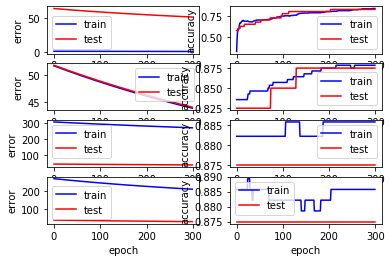

[result] train err: 1.2769832525416258, train acc: 0.9, test err: 51.18962111410491, test acc: 0.875
[result] train err: 42.852145548469665, train acc: 0.9107142857142857, test err: 42.97328925235328, test acc: 0.875
[result] train err: 260.4572133245858, train acc: 0.9142857142857143, test err: 37.28011782657725, test acc: 0.875
[result] train err: 179.67074850873223, train acc: 0.925, test err: 25.26247446203496, test acc: 0.925


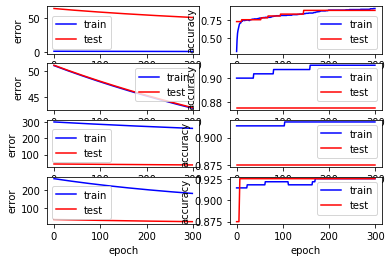

In [34]:
batch = [1, Batch_size, (N*56), (N*56)]
batch_name = ['SGD', 'mini-batch SGD', 'batch GD', 'N-R']
batch_lr = [1e-6,1e-6,1e-6,1e-2]

for dim in [2, 5, 10]: # in each dimension
    PCA_x = np.dot(train_x, V2[:, :dim])
    pca_test = np.dot(test_x, V2[:, :dim])
    w = np.zeros((5, dim))
    
    error_history = []
    acc_history = []
    
    epoch = 0
    for idx in range(4): # four methods
        b = batch[idx]
        error_history = []
        acc_history = []
        test_error_history = []
        test_acc_history = []

        epoch = 0
        #w = np.zeros((N, 28*28))

        while True: # each epoch
            epoch += 1
            batch_err_history =[]
            batch_acc_history = []
            for i in range(int(N*56/b)): # each batch
                batch_x = PCA_x[i*b:(i+1)*b]
                batch_y = train_y[i*b:(i+1)*b]
                y = softmax(np.dot(batch_x, w.T))

                error = cross_entropy(y, batch_y)
                batch_err_history.append(error)

                acc = accuracy(y, batch_y)
                batch_acc_history.append(acc)

                # update w:            
                # N-R method
                if (batch_name[idx]=='N-R'):
                    H = Hessian(batch_x, y)
                    H_inv = np.linalg.pinv(H)

                    update = np.dot(np.dot((y - batch_y).T, batch_x), H_inv)
                    w = w - update
                else:
                    w = w - batch_lr[idx] * np.dot((y - batch_y).T, batch_x)

            error = sum(batch_err_history)/len(batch_err_history)
            acc = sum(batch_acc_history)/len(batch_acc_history)


            error_history.append(error)
            acc_history.append(acc)

            # Prediction
            pred_y = softmax(np.dot(pca_test, w.T))
            pred_y_class = np.argmax(pred_y, axis = 1) + 1
            pred_acc = accuracy(pred_y, test_y)
            pred_err = cross_entropy(pred_y,test_y)

            test_acc_history.append(pred_acc)
            test_error_history.append(pred_err)
#             if epoch % 30 ==0:
#                 print(f'[Epoch {epoch}] err: {error}, acc: {acc}')

            if (1-acc) < 0.01 or epoch==300:
                print(f'[result] train err: {error}, train acc: {acc}, test err: {pred_err}, test acc: {pred_acc}')
                break
        #  TODO
        if dim == 2 and batch_name[idx]=='batch GD': #plot decision region
            color = ['r','y','g','b','w']
            test_y_class = np.argmax(test_y, axis = 1) + 1
            
            plt.figure()
            for cm in range(len(test_y_class)):
                if(test_y_class[cm] !=pred_y_class[cm]):
                    plt.scatter(pca_test[cm,0],pca_test[cm,1],c = color[pred_y_class[cm]-1],\
                                marker='x',alpha=0.5,label=pred_y_class[cm])
                    #c0_label[pred_y_class[cm]].append(pca_test[cm][0])
                    #c1_label[pred_y_class[cm]].append(pca_test[cm][1])
                else:
#                     label.append(pred_y_class[cm]-1)
                    plt.scatter(pca_test[cm,0],pca_test[cm,1],c = color[pred_y_class[cm]-1],\
                                marker='o',alpha=0.5,label=pred_y_class[cm])
                
            plt.title('2D data points')
            #plt.legend(loc='best')
            plt.show()
            
            
        
        plt.subplot(4,2,1+idx*2)
        #plt.title('PCA' + str(dim) + ' '+ batch_name[idx] + ': learning curve')
        plt.plot(range(epoch), error_history, 'b', label='train')
        plt.plot(range(epoch), test_error_history, 'r', label='test')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(loc='best')
#         plt.show()


        plt.subplot(4,2,2+idx*2)
        #plt.title('PCA' + str(dim) + ' '+ batch_name[idx] + ': accuracy')
        plt.plot(range(epoch), acc_history, 'b', label='train')
        plt.plot(range(epoch), test_acc_history, 'r', label='test')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(loc='best')
    plt.show()

In [ ]:
# np.meshgrid
